In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim
import numpy as np

In [45]:
IMG_SIZE = 64
IMG_CHANNELS = 1
NUM_CLASSES = 14
LATENT_DIM = 128
EMBEDDING_DIM = 1
BATCH_SIZE = 64
CRITIC_ITERS = 5
LAMBDA_GP = 10
EPOCHS = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PNEUMONIA_LABEL = 6

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(NUM_CLASSES, EMBEDDING_DIM)

        self.init_size = IMG_SIZE // 4  # 16 for 64x64
        self.fc = nn.Sequential(
            nn.Linear(LATENT_DIM + EMBEDDING_DIM, 128 * self.init_size ** 2)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, IMG_CHANNELS, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), dim=1)
        out = self.fc(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [35]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.label_emb = nn.Embedding(NUM_CLASSES, EMBEDDING_DIM)

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS + 1, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, stride=1, padding=0),
        )

    def forward(self, img, labels):
        label_img = self.label_emb(labels).unsqueeze(2).unsqueeze(3)
        label_img = label_img.expand(-1, -1, IMG_SIZE, IMG_SIZE)
        d_in = torch.cat((img, label_img), dim=1)
        out = self.conv_blocks(d_in)
        return out.view(out.size(0), -1).mean(1)  # return (B,) shape


In [36]:
# Gradient penalty function for WGAN-GP
def compute_gradient_penalty(critic, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = critic(interpolates, labels)
    fake = torch.ones(real_samples.size(0), requires_grad=False).to(real_samples.device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [37]:
def avg_ssim_batch(gen_imgs, real_imgs):
    gen_imgs = gen_imgs.squeeze(1).numpy()
    real_imgs = real_imgs.squeeze(1).numpy()
    return np.mean([
        ssim(g, r, data_range=2.0) for g, r in zip(gen_imgs, real_imgs)
    ])

In [46]:
def train_wgan_gp(generator, critic, dataloader):
    optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.0, 0.9))
    optimizer_C = optim.Adam(critic.parameters(), lr=2e-4, betas=(0.0, 0.9))
    scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=25, gamma=0.8)
    scheduler_C = optim.lr_scheduler.StepLR(optimizer_C, step_size=25, gamma=0.8)

    generator.to(DEVICE)
    critic.to(DEVICE)

    best_ssim_score = -1

    for epoch in range(EPOCHS):
        for i, (imgs, _) in enumerate(dataloader):
            imgs = imgs.to(DEVICE)
            labels = torch.full((imgs.size(0),), PNEUMONIA_LABEL, dtype=torch.long).to(DEVICE)

            for _ in range(CRITIC_ITERS):
                z = torch.randn(imgs.size(0), LATENT_DIM).to(DEVICE)
                fake_imgs = generator(z, labels).detach()
                real_validity = critic(imgs, labels)
                fake_validity = critic(fake_imgs, labels)
                gp = compute_gradient_penalty(critic, imgs.data, fake_imgs.data, labels)
                c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gp

                optimizer_C.zero_grad()
                c_loss.backward()
                optimizer_C.step()

            z = torch.randn(imgs.size(0), LATENT_DIM).to(DEVICE)
            gen_imgs = generator(z, labels)
            g_loss = -torch.mean(critic(gen_imgs, labels))

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

        # Optional: Delay LR scheduler until later epochs
        if epoch >= 50:
            scheduler_G.step()
            scheduler_C.step()
            

        # SSIM evaluation & save best by SSIM
        generator.eval()
        with torch.no_grad():
            z = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE)
            gen_imgs = generator(z, torch.full((BATCH_SIZE,), PNEUMONIA_LABEL, dtype=torch.long).to(DEVICE)).cpu()
            real_batch, _ = next(iter(dataloader))
            ssim_score = avg_ssim_batch(gen_imgs, real_batch[:BATCH_SIZE])
            print(f"📊 SSIM at epoch {epoch}: {ssim_score:.4f}")

            if ssim_score > best_ssim_score:
                best_ssim_score = ssim_score
                torch.save(generator.state_dict(), "best_generator_by_ssim.pth")
                print(f"💾 Saved best SSIM generator at epoch {epoch}, SSIM: {ssim_score:.4f}")
                
        generator.train()

        print(f"[Epoch {epoch+1}/{EPOCHS}] Generator Loss: {g_loss.item():.4f}, Critic Loss: {c_loss.item():.4f}")
    torch.save(generator.state_dict(), "final_generator.pth")
        


In [ ]:
# def train_wgan_gp(generator, critic, dataloader):
#     optimizer_G = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.0, 0.9))
#     optimizer_C = optim.Adam(critic.parameters(), lr=2e-4, betas=(0.0, 0.9))

#     scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=25, gamma=0.8)
#     scheduler_C = optim.lr_scheduler.StepLR(optimizer_C, step_size=25, gamma=0.8)

#     generator.to(DEVICE)
#     critic.to(DEVICE)

#     best_ssim_score = -1

#     for epoch in range(EPOCHS):
#         for i, (imgs, _) in enumerate(dataloader):
#             imgs = imgs.to(DEVICE)
#             labels = torch.full((imgs.size(0),), PNEUMONIA_LABEL, dtype=torch.long).to(DEVICE)

#             for _ in range(CRITIC_ITERS):
#                 z = torch.randn(imgs.size(0), LATENT_DIM).to(DEVICE)
#                 fake_imgs = generator(z, labels).detach()
#                 real_validity = critic(imgs, labels)
#                 fake_validity = critic(fake_imgs, labels)
#                 gp = compute_gradient_penalty(critic, imgs.data, fake_imgs.data, labels)
#                 c_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gp

#                 optimizer_C.zero_grad()
#                 c_loss.backward()
#                 optimizer_C.step()

#             z = torch.randn(imgs.size(0), LATENT_DIM).to(DEVICE)
#             gen_imgs = generator(z, labels)
#             g_loss = -torch.mean(critic(gen_imgs, labels))

#             optimizer_G.zero_grad()
#             g_loss.backward()
#             optimizer_G.step()

#         scheduler_G.step()
#         scheduler_C.step()

#         # SSIM evaluation & save best by SSIM
#         generator.eval()
#         with torch.no_grad():
#             z = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE)
#             gen_imgs = generator(z, torch.full((BATCH_SIZE,), PNEUMONIA_LABEL, dtype=torch.long).to(DEVICE)).cpu()
#             real_batch, _ = next(iter(dataloader))
#             ssim_score = avg_ssim_batch(gen_imgs, real_batch[:BATCH_SIZE])
#             print(f"📊 SSIM at epoch {epoch}: {ssim_score:.4f}")

#             if ssim_score > best_ssim_score:
#                 best_ssim_score = ssim_score
#                 torch.save(generator.state_dict(), "best_generator_by_ssim.pth")
#                 print(f"💾 Saved best SSIM generator at epoch {epoch}, SSIM: {ssim_score:.4f}")
#         generator.train()

#         print(f"[Epoch {epoch+1}/{EPOCHS}] Generator Loss: {g_loss.item():.4f}, Critic Loss: {c_loss.item():.4f}")
#     torch.save(generator.state_dict(), "final_generator.pth")


In [ ]:
# Dataset and loader setup
from torchvision import transforms
from medmnist import ChestMNIST
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([transforms.ToTensor()])

class PneumoniaDataset(Dataset):
    def __init__(self, base_dataset, label_index=6):
        self.base_dataset = base_dataset
        self.indices = [i for i in range(len(base_dataset)) if int(base_dataset[i][1][label_index]) == 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, _ = self.base_dataset[real_idx]
        img = img * 2 - 1  # normalize to [-1, 1]
        return img, 1  # dummy label

full_dataset = ChestMNIST(split='train', transform=transform, download=True,size=64)
pneumonia_dataset = PneumoniaDataset(full_dataset)
pneumonia_loader = DataLoader(pneumonia_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [48]:
# Training
generator = Generator()
critic = Critic()
train_wgan_gp(generator, critic, pneumonia_loader)


📊 SSIM at epoch 0: 0.0146
💾 Saved best SSIM generator at epoch 0, SSIM: 0.0146
[Epoch 1/200] Generator Loss: 4.8847, Critic Loss: -16.8909
📊 SSIM at epoch 1: 0.0349
💾 Saved best SSIM generator at epoch 1, SSIM: 0.0349
[Epoch 2/200] Generator Loss: 2.2568, Critic Loss: -10.3711
📊 SSIM at epoch 2: 0.0539
💾 Saved best SSIM generator at epoch 2, SSIM: 0.0539
[Epoch 3/200] Generator Loss: -0.4704, Critic Loss: -9.3975
📊 SSIM at epoch 3: 0.0787
💾 Saved best SSIM generator at epoch 3, SSIM: 0.0787
[Epoch 4/200] Generator Loss: 1.4291, Critic Loss: -8.7273
📊 SSIM at epoch 4: 0.1054
💾 Saved best SSIM generator at epoch 4, SSIM: 0.1054
[Epoch 5/200] Generator Loss: -4.2527, Critic Loss: -8.1395
📊 SSIM at epoch 5: 0.1051
[Epoch 6/200] Generator Loss: 0.4385, Critic Loss: -6.6341
📊 SSIM at epoch 6: 0.1287
💾 Saved best SSIM generator at epoch 6, SSIM: 0.1287
[Epoch 7/200] Generator Loss: 4.2083, Critic Loss: -6.1818
📊 SSIM at epoch 7: 0.1398
💾 Saved best SSIM generator at epoch 7, SSIM: 0.1398
[Epo

KeyboardInterrupt: 

In [49]:
generator = Generator().to(DEVICE)
generator.load_state_dict(torch.load("best_generator_by_ssim.pth"))
generator.eval()


Generator(
  (label_emb): Embedding(14, 1)
  (fc): Sequential(
    (0): Linear(in_features=129, out_features=32768, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [50]:
import matplotlib.pyplot as plt

# Generate random noise
z = torch.randn(16, LATENT_DIM).to(DEVICE)
labels = torch.full((16,), PNEUMONIA_LABEL, dtype=torch.long).to(DEVICE)

# Generate images
with torch.no_grad():
    gen_imgs = generator(z, labels).cpu()

# Convert from [-1, 1] → [0, 1]
gen_imgs = (gen_imgs + 1) / 2


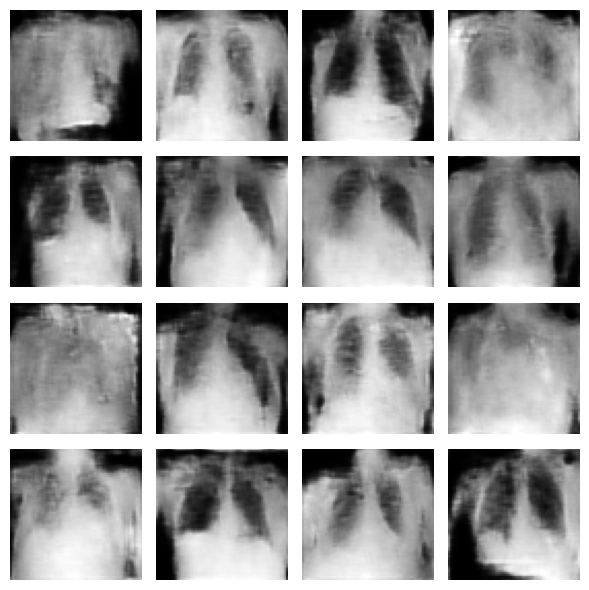

In [52]:
# Plot a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(gen_imgs[i][0], cmap='gray')
    ax.axis("off")
plt.tight_layout()
plt.show()
